In [1]:
import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, SpatialDropout2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import regularizers

Using TensorFlow backend.


In [2]:
def read_csv(directory):
    with open(directory + '/driving_log.csv', 'r') as csvfile:
        lines = []
        reader = csv.reader(csvfile)
        
        for i, line in enumerate(reader):
            if i != 0:
                lines.append(line)
    
        return lines
    
def split_on_batches(train_samples, valid_samples, size=64):
    train_lines_num = len(train_samples)
    train_batches = train_lines_num // size
    train_samples_num = size * train_batches
    train_csv_lines = train_samples[:train_samples_num]
    train = train_csv_lines, train_batches

    valid_lines_num = len(valid_samples)
    valid_batches = valid_lines_num // size
    valid_samples_num = size * valid_batches
    valid_csv_lines = valid_samples[:valid_samples_num]
    valid = valid_csv_lines, valid_batches
    
    return train, valid, size

def load_image(source_path):
    file_dir = source_path.split('/')[-4:-1]
    filename = source_path.split('/')[-1]
    path = os.path.join(*file_dir) + '/' + filename
    image = cv2.imread(path)
    image = image[60:140, :, :] # y1:y2, x1:x2
    image = cv2.resize(image, (128, 64), interpolation=cv2.INTER_AREA)
#     image = cv2.bilateralFilter(image, 5, 25, 25)
#     return np.expand_dims(image, axis=2)
    return image

# def random_shadow(image):
#     top_y = 64*np.random.uniform()
#     top_x = 0
#     bot_x = 64
#     bot_y = 64*np.random.uniform()
#     image_hls = cv2.cvtColor(image, cv2.COLOR_GRAY2HLS)
#     shadow_mask = 0*image_hls[:,:,1]
#     X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
#     Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
#     shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1

#     if np.random.randint(2)==1:
#         cond1 = shadow_mask==1
#         cond0 = shadow_mask==0
#         if np.random.randint(2)==1:
#             image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*0.5
#         else:
#             image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*0.5  
            
#     return cv2.cvtColor(image_hls,cv2.COLOR_HLS2GRAY)

# def random_brightness(image):
#     image = np.array(image, dtype=np.float64)
#     random_bright = np.random.uniform() + 0.5
#     image[:,:,0] = image[:,:,0]*random_bright
#     image[:,:,0][image1[:,:,0] > 255] = 255
    
#     return np.array(image1, dtype=np.uint8)

# def random_rotation(image, angle):
#     if angle == 0:
#         return image
    
#     angle = np.random.uniform(-angle, angle)
#     rows, cols = image.shape[:2]
#     size = cols, rows
#     center = cols / 2, rows / 2
#     scale = 1.0
#     rotation = cv2.getRotationMatrix2D(center, angle, scale)
#     return cv2.warpAffine(image, rotation, size)

# def random_translation(image, translation):
#     if translation == 0:
#         return 0
    
#     rows, cols = image.shape[:2]
#     size = cols, rows
#     x = np.random.uniform(-translation, translation)
#     y = np.random.uniform(-translation, translation)
#     trans = np.float32([[1,0,x],[0,1,y]])
#     return cv2.warpAffine(image, trans, size)

# def random_shear(image, shear):
#     if shear == 0:
#         return image
    
#     rows, cols = image.shape[:2]
#     size = cols, rows
#     left, right, top, bottom = shear, cols - shear, shear, rows - shear
#     dx = np.random.uniform(-shear, shear)
#     dy = np.random.uniform(-shear, shear)
#     p1 = np.float32([[left   , top],[right   , top   ],[left, bottom]])
#     p2 = np.float32([[left+dx, top],[right+dx, top+dy],[left, bottom+dy]])
#     move = cv2.getAffineTransform(p1,p2)
#     return cv2.warpAffine(image, move, size)

# def augment(image, brightness, angle, translation, shear):
#     image = random_brightness(image)
#     return random_shadow(image)
# #     image = random_rotation(image, angle)
# #     image = random_translation(image, translation)
# #     return random_shear(image, shear)

# def to_normalized_gray(images):
#     for i in range(len(images)):
#         img = images[i]
#         cv2.normalize(img, img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#         images[i] = img
        
#     return images

# def normalize_mean(x):
#     r = x[:,:,:,0]   
#     r_norm = (r - r.mean()) / r.std()
    
#     return np.expand_dims(r_norm, axis=3)

In [3]:
def load_features_labels(directory, line, image_idx, steering_offset):
    image = load_image(line[image_idx])
    return image, float(line[3]) + steering_offset

def augment_features(features, labels):
    shape = features.shape
    X = np.zeros((0, shape[1], shape[2], shape[3]), dtype=np.float32)
    y = np.zeros((0, 1), dtype=np.float16)
        
    for feature, label in zip(features, labels):
        flipped_feature = cv2.flip(feature, 1)
        flipped_feature = np.expand_dims(flipped_feature, axis=3)
        flipped_label = -1.0 * label
        X = np.append(X, flipped_feature[None,:], axis=0)
        y = np.append(y, flipped_label)

    for i in range(len(X)):
#         feature = augment(X[i], 0.8, 10, 20, 20)
        feature = np.expand_dims(X[i], axis=3)
        X[i] = feature
        
    return X, y
            
def build_generator(csv_lines, image_idx, steering_offset, batch_size):
    sample_shape = load_image(csv_lines[0][image_idx]).shape
    
    while True:
        X = np.zeros((0, sample_shape[0], sample_shape[1], sample_shape[2]), dtype=np.float32)
        y = np.zeros((0, 1), dtype=np.float16)
        lines_num = len(csv_lines)

        for i in range(batch_size):
            idx = np.random.choice(lines_num, 1)[0]
            line = csv_lines[idx]
            feature, label = load_features_labels(directory, line, image_idx, steering_offset)

            X = np.append(X, feature[None,:], axis=0)
            y = np.append(y, label)
#         X = normalize_mean(X)

        X = X / 255.0 - 0.5
        yield shuffle(X, y)

def train_model(model_path, train, valid, batch_size, image_idx, steering_offset, epochs):
    train_csv_lines, train_batches = train
    valid_csv_lines, valid_batches = valid

    train_samples_num = len(train_csv_lines)
    train_generator = build_generator(train_csv_lines, image_idx, steering_offset, batch_size)
    valid_samples_num = len(valid_csv_lines)
    valid_generator = build_generator(valid_csv_lines, image_idx, steering_offset, batch_size)

    model = None
    show_summary = False
    
    if Path(model_path + ".json").is_file():
        with open(model_path + ".json", "r") as json_file:
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(model_path + ".h5")
            print("Loaded model from disk")
    else:
        show_summary = True

    learn = 0.0001
    
    if model is None:
        print("Create new model")
        model = Sequential()
        
        model.add(Conv2D(32, 5, 5, border_mode='same', subsample=(2, 2), input_shape=(64, 128, 3)))
        model.add(BatchNormalization())
        model.add(ELU())
        
        model.add(Conv2D(16, 3, 3, border_mode='valid', subsample=(1, 1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(Dropout(0.4))
        model.add(MaxPooling2D((2, 2), border_mode='valid'))
        
        model.add(Conv2D(16, 3, 3, border_mode='valid', subsample=(1, 1)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(Dropout(0.4))
        
        model.add(Conv2D(16, 3, 3, border_mode='same', subsample=(2, 2)))
        model.add(BatchNormalization())
        model.add(ELU())
        model.add(MaxPooling2D((2, 2), border_mode='valid'))
        
        model.add(Flatten())
        
        model.add(Dense(1024))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        model.add(ELU())
        
        model.add(Dense(512))
        model.add(BatchNormalization())
        model.add(ELU())
        
        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(ELU())
        
        model.add(Dense(1))
    
    optimizer = Adam(lr=learn)
    model.compile(loss='mse', optimizer=optimizer)
    history_object = model.fit_generator(train_generator, samples_per_epoch=train_samples_num, validation_data=valid_generator, nb_val_samples=valid_samples_num, nb_epoch=epochs, verbose=1)

    if show_summary:
        model.summary()

    model_json = model.to_json()
    with open(model_path + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_path + ".h5")
#     print("Saved model to disk")
    
#     print(history_object.history.keys())
#     plt.plot(history_object.history['loss'])
#     plt.plot(history_object.history['val_loss'])
#     plt.title('model mean squared error loss')
#     plt.ylabel('mean squared error loss')
#     plt.xlabel('epoch')
#     plt.legend(['training set', 'validation set'], loc='upper right')
#     plt.show()

def analyze_and_filter(lines):
    steerings = [float(row[3]) for row in lines]

    num_bins = 100
    avg_samples_per_bin = len(steerings) / num_bins
    hist, bins = np.histogram(steerings, num_bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steerings), np.max(steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    # determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
    # to number of samples above the average, so as to bring the number of samples for that bin down to the average
    keep_probs = []
    target = avg_samples_per_bin * 0.5
    remove_list = []
    
    for i in range(num_bins):
        if hist[i] < target:
            keep_probs.append(1.0)
        else:
            keep_probs.append(1.0 / (hist[i] / target))

    for i in range(len(steerings)):
        for j in range(num_bins):
            if steerings[i] > bins[j] and steerings[i] <= bins[j+1]:
                # delete from X and y with probability 1 - keep_probs[j]
                if np.random.rand() > keep_probs[j]:
                    remove_list.append(i)
                    
    csv_filtered = np.delete(lines, remove_list, axis=0)
    filtered_steerings = np.delete(steerings, remove_list)

    hist, bins = np.histogram(filtered_steerings, num_bins)
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(filtered_steerings), np.max(filtered_steerings)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

    filtered_steerings = [float(row[3]) for row in csv_filtered]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.hist(steerings, bins=100)
    ax2.hist(filtered_steerings, bins=100)
    plt.show()
    
    return csv_filtered
    
def load_data(directory):
    csv_lines = read_csv(directory)
    sample_center = load_image(csv_lines[0][0])
    sample_left = load_image(csv_lines[0][1])
    sample_right = load_image(csv_lines[0][2])

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
    plt.axis("off")
    img = cv2.cvtColor(sample_center, cv2.COLOR_BGR2RGB)
    ax1.imshow(img)
    img = cv2.cvtColor(sample_left, cv2.COLOR_BGR2RGB)
    ax2.imshow(img)
    img = cv2.cvtColor(sample_right, cv2.COLOR_BGR2RGB)
    ax3.imshow(img)
    plt.show()
    
    return csv_lines

data/Track1.1/driving_log.csv


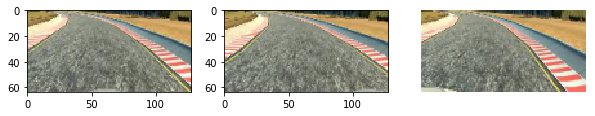

data/Track1.2/driving_log.csv


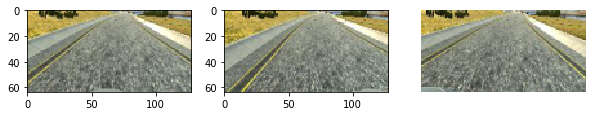

data/Track1.3/driving_log.csv


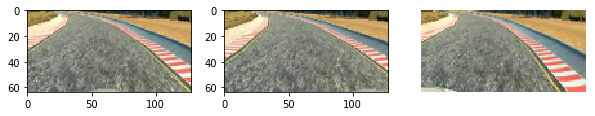

data/Track1.4/driving_log.csv


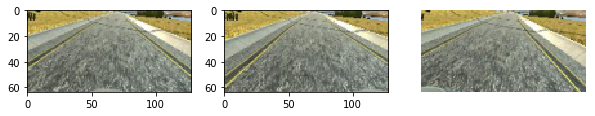

data/Track1.5/driving_log.csv


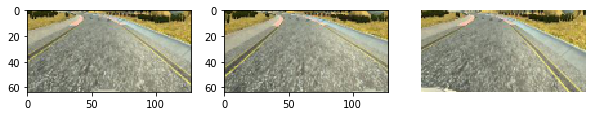

data/Track1.6/driving_log.csv


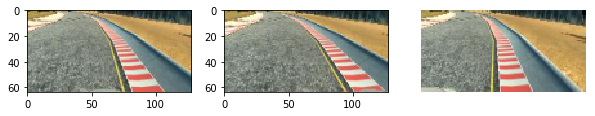

data/Track1.7 - left border/driving_log.csv


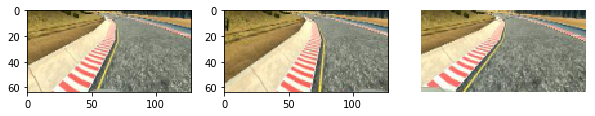

data/Track1.8 - borders/driving_log.csv


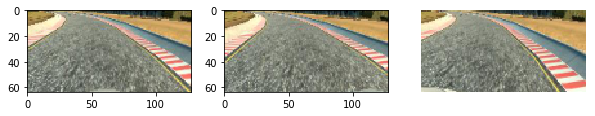

data/Track1.9 - full/driving_log.csv


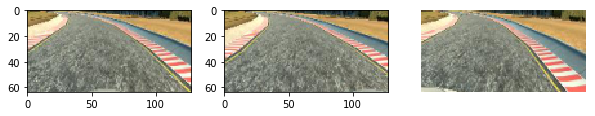

data/Track1.9.1 - full/driving_log.csv


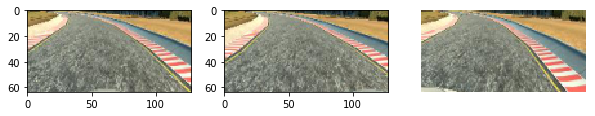

data/Track1.9.2 - full/driving_log.csv


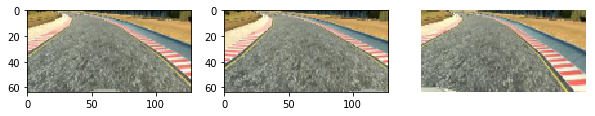

data/Track1.9.3 - full/driving_log.csv


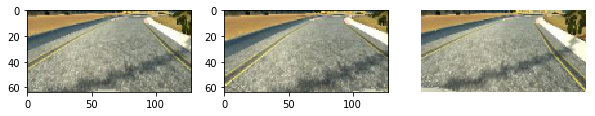

data/Track1.9.4 - full/driving_log.csv


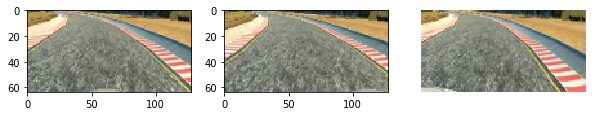

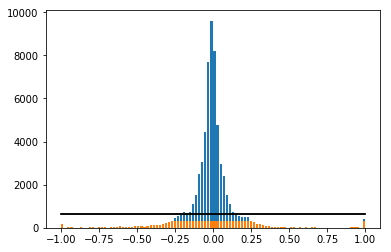

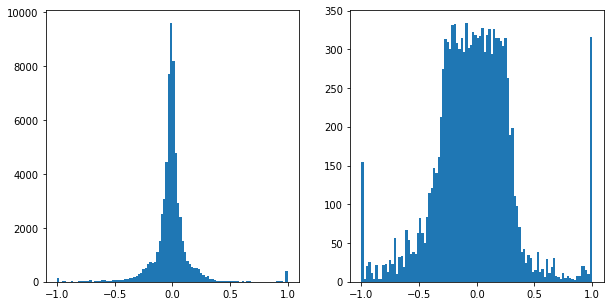

Create new model
Epoch 1/5
50304/50304 [==============================] - 1695s - loss: 0.1076 - val_loss: 0.0283
Epoch 2/5
50304/50304 [==============================] - 1535s - loss: 0.0228 - val_loss: 0.0204
Epoch 3/5
50304/50304 [==============================] - 1510s - loss: 0.0181 - val_loss: 0.0200
Epoch 4/5
50304/50304 [==============================] - 1513s - loss: 0.0159 - val_loss: 0.0166
Epoch 5/5
50304/50304 [==============================] - 1528s - loss: 0.0147 - val_loss: 0.0186
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 64, 32)    2432        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 32, 64, 32)    128         convolution2d_1[0][0]      

In [4]:
csv_lines = []

directory = "data/Track1.1" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.2" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.3" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.4" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.5" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.6" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.7 - left border" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.8 - borders" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.9 - full" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.9.1 - full" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.9.2 - full" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.9.3 - full" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

directory = "data/Track1.9.4 - full" #full
lines = load_data(directory)
csv_lines = csv_lines + lines

filtered_lines = analyze_and_filter(csv_lines)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model("model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [74]:
directory = "data/Track1.1 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

data/Track1.1 - full/driving_log.csv
data/Track1.1/IMG/center_2017_07_23_23_45_56_804.jpg
None


TypeError: 'NoneType' object is not subscriptable

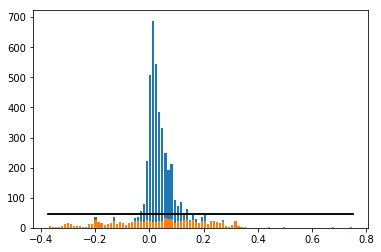

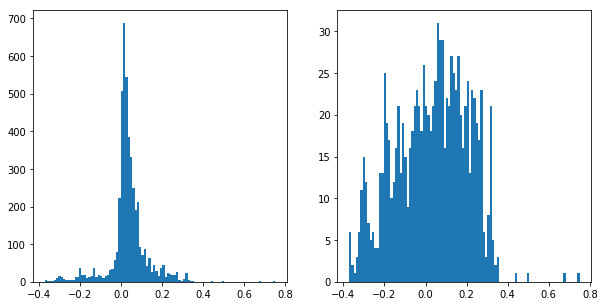

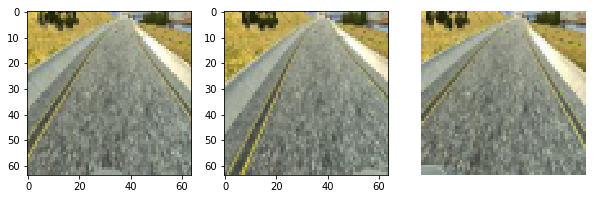

Loaded model from disk
Epoch 1/5
768/768 [==============================] - 18s - loss: 0.0274 - val_loss: 0.0110
Epoch 2/5
768/768 [==============================] - 13s - loss: 0.0220 - val_loss: 0.0082
Epoch 3/5
768/768 [==============================] - 13s - loss: 0.0149 - val_loss: 0.0106
Epoch 4/5
768/768 [==============================] - 13s - loss: 0.0143 - val_loss: 0.0122
Epoch 5/5
768/768 [==============================] - 15s - loss: 0.0116 - val_loss: 0.0122
Loaded model from disk
Epoch 1/5
768/768 [==============================] - 21s - loss: 0.0217 - val_loss: 0.0183
Epoch 2/5
768/768 [==============================] - 13s - loss: 0.0170 - val_loss: 0.0112
Epoch 3/5
768/768 [==============================] - 13s - loss: 0.0151 - val_loss: 0.0086
Epoch 4/5
768/768 [==============================] - 12s - loss: 0.0116 - val_loss: 0.0074
Epoch 5/5
768/768 [==============================] - 13s - loss: 0.0118 - val_loss: 0.0069
Loaded model from disk
Epoch 1/5
768/768 [==

In [6]:
directory = "data/Track1.2 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.3 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.4 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.5 - hard"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right


for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.6 - right border"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [5]:
directory = "data/Track1.7 - left border"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

TypeError: '_csv.reader' object is not subscriptable

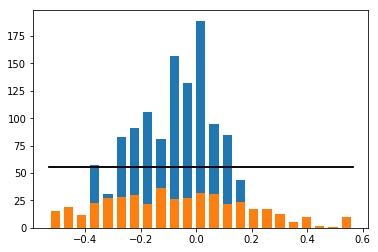

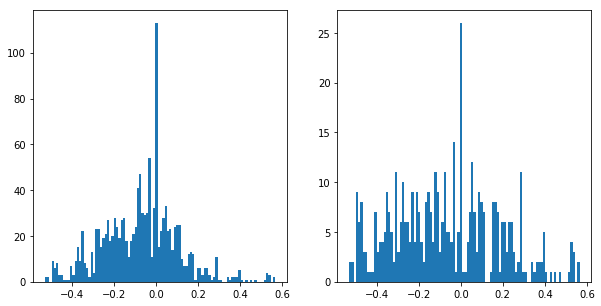

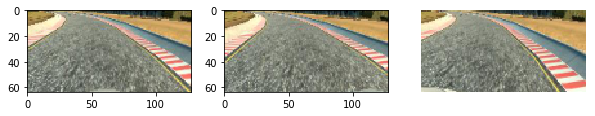

Loaded model from disk
Epoch 1/5
320/320 [==============================] - 11s - loss: 0.0724 - val_loss: 0.1034
Epoch 2/5
320/320 [==============================] - 6s - loss: 0.0516 - val_loss: 0.0825
Epoch 3/5
320/320 [==============================] - 6s - loss: 0.0658 - val_loss: 0.0668
Epoch 4/5
320/320 [==============================] - 5s - loss: 0.0569 - val_loss: 0.0727
Epoch 5/5
320/320 [==============================] - 5s - loss: 0.0630 - val_loss: 0.0801
Loaded model from disk
Epoch 1/5
320/320 [==============================] - 11s - loss: 0.0644 - val_loss: 0.0485
Epoch 2/5
320/320 [==============================] - 5s - loss: 0.0621 - val_loss: 0.0705
Epoch 3/5
320/320 [==============================] - 6s - loss: 0.0653 - val_loss: 0.0671
Epoch 4/5
320/320 [==============================] - 6s - loss: 0.0607 - val_loss: 0.0598
Epoch 5/5
320/320 [==============================] - 6s - loss: 0.0679 - val_loss: 0.0635
Loaded model from disk
Epoch 1/5
320/320 [==========

In [12]:
directory = "data/Track1.8 - borders"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

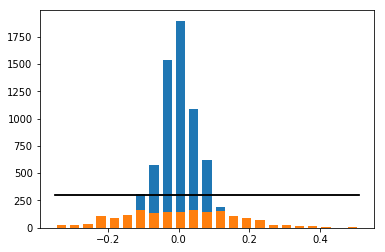

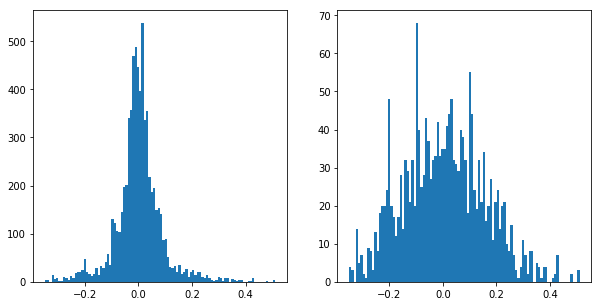

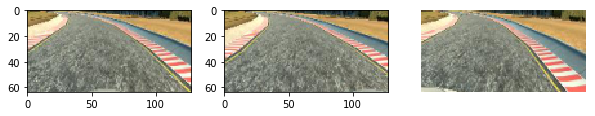

Loaded model from disk
Epoch 1/5
1408/1408 [==============================] - 49s - loss: 0.0258 - val_loss: 0.0254
Epoch 2/5
1408/1408 [==============================] - 30s - loss: 0.0239 - val_loss: 0.0232
Epoch 3/5
1344/1408 [===========================>..] - ETA: 0s - loss: 0.0232

KeyboardInterrupt: 

In [13]:
directory = "data/Track1.9 - full" 
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.9.1 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track2.0 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track2.1 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track2.2 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.9.2 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.9.3 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")

In [ ]:
directory = "data/Track1.9.4 - full"
csv_lines = load_data(directory)
steering_offsets = [0.0, 0.08, -0.08] # center, left, right

for idx, offset in enumerate(steering_offsets):
    train_samples, valid_samples = train_test_split(csv_lines, test_size=0.2)
    train, valid, size = split_on_batches(train_samples, valid_samples)
    train_model(directory, "model/p3_model", train, valid, size, image_idx=idx, steering_offset=offset, epochs=5)
    
print("We're done")